In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to Google Drive
drive.mount('/content/drive')

# Define the base path
base_path = '/content/drive/MyDrive/'

# Define the paths to benign and malignant folders within the train and test folders
train_benign_path = os.path.join(base_path, 'melanoma_cancer_dataset/train/benign')
train_malignant_path = os.path.join(base_path, 'melanoma_cancer_dataset/train/malignant')

test_benign_path = os.path.join(base_path, 'melanoma_cancer_dataset/test/benign')
test_malignant_path = os.path.join(base_path, 'melanoma_cancer_dataset/test/malignant')

Mounted at /content/drive


In [2]:
!pip install seaborn

In [3]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(180, 180))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Function to load a subset of images from a folder
def load_images_subset(folder, label, num_images):
    images = []
    labels = []

    # List all files in the folder
    file_list = os.listdir(folder)

    # Take a subset of the files
    selected_files = file_list[:num_images]

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

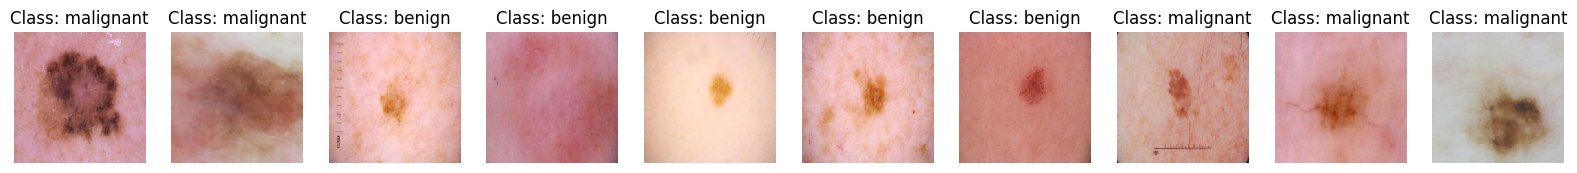

In [9]:
# Function to load a subset of images from a folder
def load_images_subset_with_labels(folder, label, num_images, image_datagen=None):
    images = []
    labels = []

    # List all files in the folder
    file_list = os.listdir(folder)

    # Take a subset of the files
    selected_files = file_list[:num_images]

    for filename in selected_files:
        img_path = os.path.join(folder, filename)

        # Use image_datagen if provided, otherwise load the original image
        if image_datagen:
            img = image_datagen.random_transform(load_and_preprocess_image_without_preprocess_input(img_path))
        else:
            img = load_and_preprocess_image_without_preprocess_input(img_path)

        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Load a subset of benign and malignant images for visualization without data augmentation
num_images_to_visualize = 5

# Load benign images without augmentation
benign_images, benign_labels = load_images_subset_with_labels(train_benign_path, label="benign", num_images=num_images_to_visualize, image_datagen=None)

# Load malignant images without augmentation
malignant_images, malignant_labels = load_images_subset_with_labels(train_malignant_path, label="malignant", num_images=num_images_to_visualize, image_datagen=None)

# Concatenate benign and malignant images and labels
all_images = np.concatenate([benign_images, malignant_images])
all_labels = np.concatenate([benign_labels, malignant_labels])

# Shuffle the data
all_images, all_labels = shuffle(all_images, all_labels)

# Function to plot images
def plot_images_with_labels(images, labels):
    plt.figure(figsize=(20, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {labels[i]}")
        plt.axis('off')
    plt.show()

# Plot the original images with "benign" or "malignant" labels
plot_images_with_labels(all_images, all_labels)


In [4]:
# Specify the number of images to load from each class
num_images_per_class = 3000

# Load a subset of images from each class in the training set
train_benign_images, train_benign_labels = load_images_subset(train_benign_path, 0, num_images_per_class)
train_malignant_images, train_malignant_labels = load_images_subset(train_malignant_path, 1, num_images_per_class)

# Load a subset of images from each class in the testing set
test_benign_images, test_benign_labels = load_images_subset(test_benign_path, 0, num_images_per_class)
test_malignant_images, test_malignant_labels = load_images_subset(test_malignant_path, 1, num_images_per_class)

# Concatenate the data for train and test sets
train_images = np.concatenate((train_benign_images, train_malignant_images), axis=0)
train_labels = np.concatenate((train_benign_labels, train_malignant_labels), axis=0)

test_images = np.concatenate((test_benign_images, test_malignant_images), axis=0)
test_labels = np.concatenate((test_benign_labels, test_malignant_labels), axis=0)

# Shuffle the data for train and test sets
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

# Split the data into training and testing sets
X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels

# Create the generators
batch_size = 32
img_height, img_width = 180, 180

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

# base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
# base_model.trainable = True  # You can experiment with fine-tuning

# Define the model
model = Sequential([

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),  # Adjusted dropout rate

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Adjusted dropout rate

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy']
)

# Assuming img_height and img_width are the dimensions of your input images
input_shape = (img_height, img_width, 3)

# Build the model
model.build(input_shape=(None, *input_shape))

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 128)       0

In [6]:
epochs = 20
# Train the model using the generator
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/20
188/188 [==============================] - 60s 279ms/step - loss: 0.3980 - accuracy: 0.8230 - val_loss: 0.2685 - val_accuracy: 0.8850
Epoch 2/20
188/188 [==============================] - 52s 275ms/step - loss: 0.3237 - accuracy: 0.8667 - val_loss: 0.2422 - val_accuracy: 0.8980
Epoch 3/20
188/188 [==============================] - 51s 270ms/step - loss: 0.2965 - accuracy: 0.8753 - val_loss: 0.2420 - val_accuracy: 0.9060
Epoch 4/20
188/188 [==============================] - 54s 285ms/step - loss: 0.2890 - accuracy: 0.8805 - val_loss: 0.2339 - val_accuracy: 0.9050
Epoch 5/20
188/188 [==============================] - 51s 270ms/step - loss: 0.2758 - accuracy: 0.8885 - val_loss: 0.2208 - val_accuracy: 0.9030
Epoch 6/20
188/188 [==============================] - 51s 270ms/step - loss: 0.2679 - accuracy: 0.8888 - val_loss: 0.2309 - val_accuracy: 0.9100
Epoch 7/20
188/188 [==============================] - 53s 281ms/step - loss: 0.2492 - accuracy: 0.8980 - val_loss: 0.2361 - val_ac

1/1 [==============================] - 0s 77ms/step

Results for Model 1:


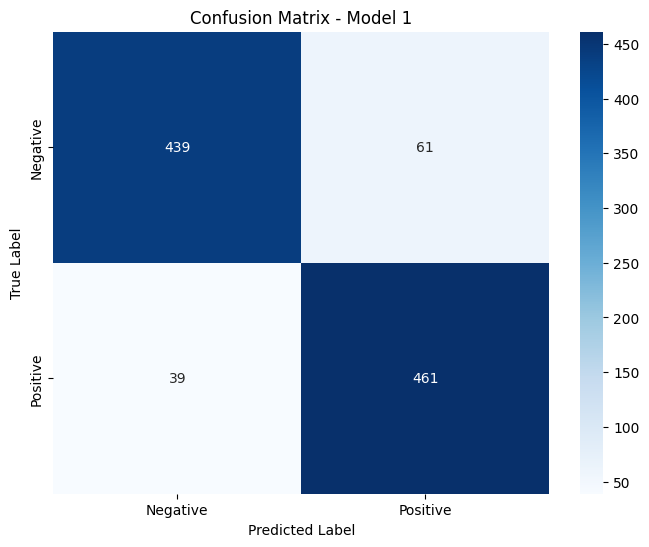


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       500
           1       0.88      0.92      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [7]:
# Evaluate the model with a lower threshold for classifying as malignant
threshold = 0.3  # You can adjust this threshold
y_true = []
y_pred = []

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    true_labels = labels
    predictions = (model.predict(images) > threshold).astype(int)

    y_true.extend(true_labels)
    y_pred.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

model_name = 'Model 1'

print(f"\nResults for {model_name}:")

# Display confusion matrix as a heatmap
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred))


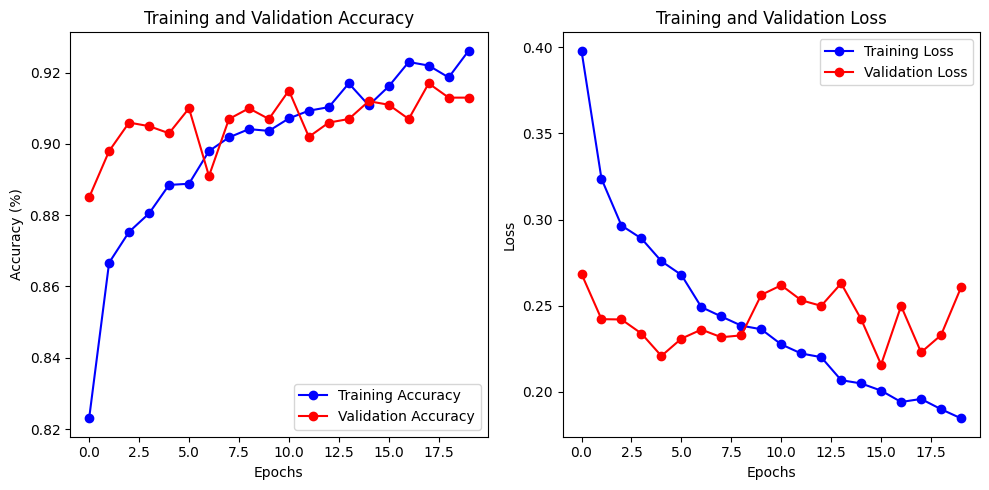

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [9]:
from google.colab import files

# Збереження ваг 1 моделі
model.save_weights('model_1.h5')
# Завантаження файлу з Google Colab
files.download('model_1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>